In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import spotipy
import time
from IPython.core.display import clear_output
from spotipy import SpotifyClientCredentials, util

#Populate client_id, client_secret, username
client_id=''
client_secret=''
redirect_uri='http://localhost:8080/'
username = ''
scope = 'playlist-modify-public'

#Credentials to access the Spotify Music Data
manager = SpotifyClientCredentials(client_id,client_secret)
sp = spotipy.Spotify(client_credentials_manager=manager)

#Credentials to access to  the Spotify User's Playlist, Favorite Songs, etc. 
token = util.prompt_for_user_token(username,scope,client_id,client_secret,redirect_uri) 
spt = spotipy.Spotify(auth=token)


def get_albums_id(ids):
    album_ids = []
    results = sp.artist_albums(ids)
    for album in results['items']:
        album_ids.append(album['id'])
    return album_ids

def get_album_songs_id(ids):
    song_ids = []
    results = sp.album_tracks(ids,offset=0)
    for songs in results['items']:
        song_ids.append(songs['id'])
    return song_ids

def get_songs_features(ids):

    meta = sp.track(ids)
    features = sp.audio_features(ids)

    # meta
    name = meta['name']
    album = meta['album']['name']
    artist = meta['album']['artists'][0]['name']
    release_date = meta['album']['release_date']
    length = meta['duration_ms']
    popularity = meta['popularity']
    ids =  meta['id']

    # features
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    instrumentalness = features[0]['instrumentalness']
    liveness = features[0]['liveness']
    valence = features[0]['valence']
    loudness = features[0]['loudness']
    speechiness = features[0]['speechiness']
    tempo = features[0]['tempo']
    key = features[0]['key']
    time_signature = features[0]['time_signature']

    track = [name, album, artist, ids, release_date, popularity, length, danceability, acousticness,
            energy, instrumentalness, liveness, valence, loudness, speechiness, tempo, key, time_signature]
    columns = ['name','album','artist','id','release_date','popularity','length','danceability','acousticness','energy','instrumentalness',
                'liveness','valence','loudness','speechiness','tempo','key','time_signature']
    return track,columns

def get_songs_artist_ids_playlist(ids):
    playlist = sp.playlist_tracks(ids)
    songs_id = []
    artists_id = []
    for result in playlist['items']:
        songs_id.append(result['track']['id'])
        for artist in result['track']['artists']:
            artists_id.append(artist['id'])
    return songs_id,artists_id

def download_albums(music_id,artist=False):
    
    if artist == True:
        ids_album = get_albums_id(music_id)
    else:
        if type(music_id) == list:
            ids_album = music_id
        elif type(music_id) == str:
            ids_album = list([music_id])

    tracks = []
    for ids in ids_album:
        #Obtener Ids de canciones en album
        song_ids = get_album_songs_id(ids=ids)
        #Obtener feautres de canciones en album
        ids2 = song_ids
        
        print(f"Album Length: {len(song_ids)}")
         
        time.sleep(.6)   
        track, columns = get_songs_features(ids2)
        tracks.append(track)

        print(f"Song Added: {track[0]} By {track[2]} from the album {track[1]}")
        clear_output(wait = True)
        
    clear_output(wait = True)
    print("Music Downloaded!")
 
    return tracks,columns

def download_playlist(id_playlist,n_songs):
    songs_id = []
    tracks = []

    for i in range(0,n_songs,100):
        playlist = spt.playlist_tracks(id_playlist,limit=100,offset=i)
        
        for songs in playlist['items']:
            songs_id.append(songs['track']['id'])
    
    counter = 1
    for ids in songs_id:
        
        time.sleep(.6)
        track,columns = get_songs_features(ids)
        tracks.append(track)

        print(f"Song {counter} Added:")
        print(f"{track[0]} By {track[2]} from the album {track[1]}")
        clear_output(wait = True)
        counter+=1
    
    clear_output(wait = True)
    print("Music Downloaded!")

    return tracks,columns

/var/folders/6q/1tr6dsz903s0r57yd4bx3jrm0000gn/T/ipykernel_3027/3652984379.py:3: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import clear_output


In [3]:
songs_list = pd.read_csv("dataset.csv")

In [4]:
trackFeatures = songs_list.groupby(['mood']).mean()
print(trackFeatures)

           popularity         length  danceability  acousticness    energy  \
mood                                                                         
Calm        40.261538  193977.061538      0.406815      0.883348  0.156325   
Energetic   41.603896  215779.948052      0.512240      0.028229  0.883669   
Happy       48.585714  230963.850000      0.622914      0.127849  0.751857   
Sad         37.730964  247504.472081      0.497245      0.578826  0.388068   

           instrumentalness  liveness   valence   loudness  speechiness  \
mood                                                                      
Calm               0.890769  0.115418  0.151421 -20.955826     0.040742   
Energetic          0.056607  0.233897  0.437049  -4.695844     0.079170   
Happy              0.126103  0.201682  0.579095  -7.275750     0.061774   
Sad                0.201832  0.140655  0.289372 -10.569183     0.041736   

                tempo       key  time_signature  
mood                          

In [5]:
col_features = songs_list.columns[6:-3]
#Storing the required features in X
X = songs_list[col_features]
#Storing the target result in Y
Y = songs_list['mood']

In [6]:
#Feature normalization using min-max
X = MinMaxScaler().fit_transform(X)

In [67]:
#Encode the labels (targets)
label_encoder = LabelEncoder()
label_encoder.fit(Y)
y_encoded = label_encoder.transform(Y)

In [8]:
mood_vs_encoder = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
mood_vs_encoder 

{'Calm': 0, 'Energetic': 1, 'Happy': 2, 'Sad': 3}

In [9]:
#Split train and test data with a test size of 15%
X_train,X_test,y_train,y_test = train_test_split(X,y_encoded,test_size=0.15,random_state=15)

In [10]:
target = pd.DataFrame({'mood':songs_list['mood'].tolist(),'encode':y_encoded}).drop_duplicates().sort_values(['encode'],ascending=True)
target

,mood,encode
5,Calm,0
4,Energetic,1
0,Happy,2
1,Sad,3


In [34]:
#Creating base model with 4 hidden layers
def model_base4():
    baseModel = Sequential()
    #Adding a layer with 4 nodes, 4 dimensional input with relu function.
    baseModel.add(Dense(4,input_dim=10,activation='relu'))
    #Adding a layer with 4 outputs and softmax function
    baseModel.add(Dense(4,activation='softmax'))
    #Compiling the model adam optimizer and sigmoid loss function
    baseModel.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    return baseModel

In [35]:
#Creating base model with 5 hidden layers
def model_base5():
    baseModel = Sequential()
    #Adding a layer with 5 nodes, 4 dimensional input with relu function.
    baseModel.add(Dense(5,input_dim=10,activation='relu'))
    #Adding a layer with 4 outputs and softmax function
    baseModel.add(Dense(4,activation='softmax'))
    #Compiling the model adam optimizer and sigmoid loss function
    baseModel.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    return baseModel

In [36]:
#Creating base model with 6 hidden layers
def model_base6():
    baseModel = Sequential()
    #Adding a layer with 6 nodes, 4 dimensional input with relu function.
    baseModel.add(Dense(6,input_dim=10,activation='relu'))
    #Adding a layer with 4 outputs and softmax function
    baseModel.add(Dense(4,activation='softmax'))
    #Compiling the model adam optimizer and sigmoid loss function
    baseModel.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    return baseModel

In [37]:
#Creating base model with 7 hidden layers
def model_base7():
    baseModel = Sequential()
    #Adding a layer with 7 nodes, 4 dimensional input with relu function.
    baseModel.add(Dense(7,input_dim=10,activation='relu'))
    #Adding a layer with 4 outputs and softmax function
    baseModel.add(Dense(4,activation='softmax'))
    #Compiling the model adam optimizer and sigmoid loss function
    baseModel.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    return baseModel

In [38]:
#Creating base model with 8 hidden layers
def model_base8():
    baseModel = Sequential()
    #Adding a layer with 8 nodes, 4 dimensional input with relu function.
    baseModel.add(Dense(8,input_dim=10,activation='relu'))
    #Adding a layer with 4 outputs and softmax function
    baseModel.add(Dense(4,activation='softmax'))
    #Compiling the model adam optimizer and sigmoid loss function
    baseModel.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    return baseModel

In [39]:
#Creating base model with 9 hidden layers
def model_base9():
    baseModel = Sequential()
    #Adding a layer with 9 nodes, 4 dimensional input with relu function.
    baseModel.add(Dense(9,input_dim=10,activation='relu'))
    #Adding a layer with 4 outputs and softmax function
    baseModel.add(Dense(4,activation='softmax'))
    #Compiling the model adam optimizer and sigmoid loss function
    baseModel.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    return baseModel

In [40]:
#Creating base model with 10 hidden layers
def model_base10():
    baseModel = Sequential()
    #Adding a layer with 10 nodes, 4 dimensional input with relu function.
    baseModel.add(Dense(10,input_dim=10,activation='relu'))
    #Adding a layer with 4 outputs and softmax function
    baseModel.add(Dense(4,activation='softmax'))
    #Compiling the model adam optimizer and sigmoid loss function
    baseModel.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    return baseModel

In [41]:
#Evaluation of the model by KFold cross validation for model with 4 hidden layers
def evaluate_model(classifier, X, y_encoded):
    kfold = KFold(n_splits=10,shuffle=True)
    results = cross_val_score(classifier,X,y_encoded,cv=kfold)
    print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100,results.std()*100))

In [42]:
def predict(classifier, X_train, y_train):
    classifier.fit(X_train,y_train)
    y_prediction = classifier.predict(X_test)
    return y_prediction

In [43]:
def draw_confusion_matrix(y_test, y_prediction):
    conf_matrix = confusion_matrix(y_test,y_prediction)
    plot = plt.subplot()
    sns.heatmap(conf_matrix,annot=True,ax=plot)
    moods = target['mood']
    plot.set_title('Confusion Matrix')
    plot.set_xlabel('Predicted labels')
    plot.set_ylabel('True labels')
    plot.xaxis.set_ticklabels(moods)
    plot.yaxis.set_ticklabels(moods)
    plt.show()

In [44]:
def find_accuracy_score(y_test,y_prediction):
    accuracy = accuracy_score(y_test,y_prediction)
    return accuracy 

In [45]:
accuracy_score_list = []

/var/folders/6q/1tr6dsz903s0r57yd4bx3jrm0000gn/T/ipykernel_3027/3395945716.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier4 = KerasClassifier(build_fn=model_base4,epochs=300,batch_size=200,verbose=0)
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in

Baseline: 74.22% (4.07%)


/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


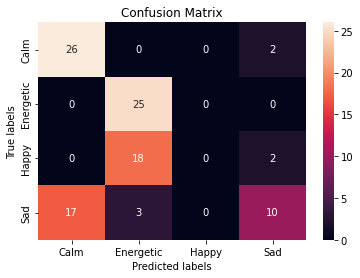

Accuracy for model with 4 hidden layers :  0.5922330097087378


In [46]:
#Model configuration for hiddel layer 4
classifier4 = KerasClassifier(build_fn=model_base4,epochs=300,batch_size=200,verbose=0)
evaluate_model(classifier4, X, y_encoded) 
y_pred4 = predict(classifier4,X_train, y_train)
draw_confusion_matrix(y_test, y_pred4)
accuracy = find_accuracy_score(y_test, y_pred4)
print("Accuracy for model with 4 hidden layers : " , accuracy)
accuracy_score_list.append(accuracy)

/var/folders/6q/1tr6dsz903s0r57yd4bx3jrm0000gn/T/ipykernel_3027/3509805319.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier5 = KerasClassifier(build_fn=model_base5,epochs=300,batch_size=200,verbose=0)
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in

Baseline: 77.38% (5.33%)


/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


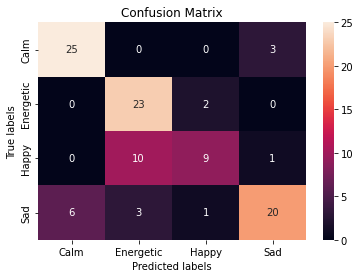

Accuracy for model with 5 hidden layers :  0.7475728155339806


In [47]:
classifier5 = KerasClassifier(build_fn=model_base5,epochs=300,batch_size=200,verbose=0)
evaluate_model(classifier5, X, y_encoded)
y_pred5 = predict(classifier5,X_train, y_train)
draw_confusion_matrix(y_test, y_pred5)
accuracy = find_accuracy_score(y_test, y_pred5)
print("Accuracy for model with 5 hidden layers : " , accuracy)
accuracy_score_list.append(accuracy)

/var/folders/6q/1tr6dsz903s0r57yd4bx3jrm0000gn/T/ipykernel_3027/2435246712.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier6 = KerasClassifier(build_fn=model_base6,epochs=300,batch_size=200,verbose=0)
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in

Baseline: 77.85% (6.21%)


/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


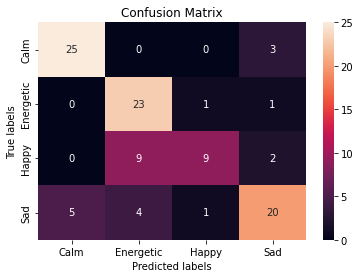

Accuracy for model with 6 hidden layers :  0.7475728155339806


In [48]:
classifier6 = KerasClassifier(build_fn=model_base6,epochs=300,batch_size=200,verbose=0)
evaluate_model(classifier6, X, y_encoded)
y_pred6 = predict(classifier6,X_train, y_train)
draw_confusion_matrix(y_test, y_pred6)
accuracy = find_accuracy_score(y_test, y_pred6)
print("Accuracy for model with 6 hidden layers : " , accuracy)
accuracy_score_list.append(accuracy)

/var/folders/6q/1tr6dsz903s0r57yd4bx3jrm0000gn/T/ipykernel_3027/1499338477.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier7 = KerasClassifier(build_fn=model_base7,epochs=300,batch_size=200,verbose=0)
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in

Baseline: 79.02% (5.26%)


/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


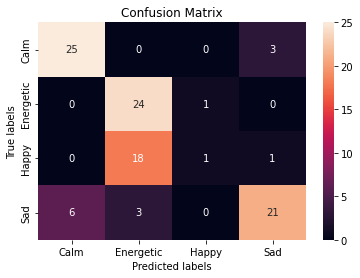

Accuracy for model with 7 hidden layers :  0.6893203883495146


In [49]:
classifier7 = KerasClassifier(build_fn=model_base7,epochs=300,batch_size=200,verbose=0)
evaluate_model(classifier7, X, y_encoded)
y_pred7 = predict(classifier7,X_train, y_train)
draw_confusion_matrix(y_test, y_pred7)
accuracy = find_accuracy_score(y_test, y_pred7)
print("Accuracy for model with 7 hidden layers : " , accuracy)
accuracy_score_list.append(accuracy)

/var/folders/6q/1tr6dsz903s0r57yd4bx3jrm0000gn/T/ipykernel_3027/1160969786.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier8 = KerasClassifier(build_fn=model_base8,epochs=300,batch_size=200,verbose=0)
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in

Baseline: 80.33% (3.57%)


/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


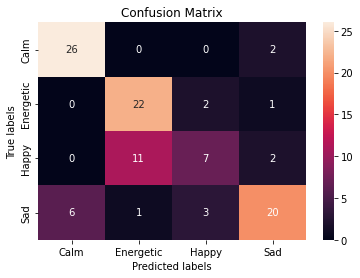

Accuracy for model with 8 hidden layers :  0.7281553398058253


In [50]:
classifier8 = KerasClassifier(build_fn=model_base8,epochs=300,batch_size=200,verbose=0)
evaluate_model(classifier8, X, y_encoded)
y_pred8 = predict(classifier8,X_train, y_train)
draw_confusion_matrix(y_test, y_pred8)
accuracy = find_accuracy_score(y_test, y_pred8)
print("Accuracy for model with 8 hidden layers : " , accuracy)
accuracy_score_list.append(accuracy)

/var/folders/6q/1tr6dsz903s0r57yd4bx3jrm0000gn/T/ipykernel_3027/3974727850.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier9 = KerasClassifier(build_fn=model_base9,epochs=300,batch_size=200,verbose=0)
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in

Baseline: 79.16% (5.26%)


/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


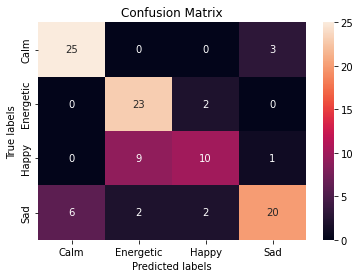

Accuracy for model with 9 hidden layers :  0.7572815533980582


In [51]:
classifier9 = KerasClassifier(build_fn=model_base9,epochs=300,batch_size=200,verbose=0)
evaluate_model(classifier9, X, y_encoded)
y_pred9 = predict(classifier9,X_train, y_train)
draw_confusion_matrix(y_test, y_pred9)
accuracy = find_accuracy_score(y_test, y_pred9)
print("Accuracy for model with 9 hidden layers : " , accuracy)
accuracy_score_list.append(accuracy)

/var/folders/6q/1tr6dsz903s0r57yd4bx3jrm0000gn/T/ipykernel_3027/3904848179.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier10 = KerasClassifier(build_fn=model_base10,epochs=300,batch_size=200,verbose=0)
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed 

Baseline: 79.58% (5.66%)


/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


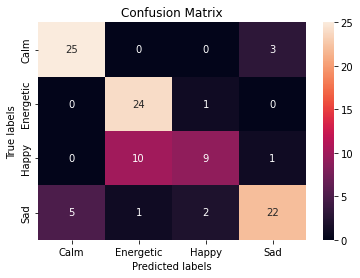

Accuracy:  0.7766990291262136


In [52]:
classifier10 = KerasClassifier(build_fn=model_base10,epochs=300,batch_size=200,verbose=0)
evaluate_model(classifier10, X, y_encoded)
y_pred10 = predict(classifier10,X_train, y_train)
draw_confusion_matrix(y_test, y_pred10)
accuracy = find_accuracy_score(y_test, y_pred10)
print("Accuracy: " , accuracy)
#accuracy_score_list.append(accuracy)

In [68]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred10))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86        28
           1       0.69      0.96      0.80        25
           2       0.75      0.45      0.56        20
           3       0.85      0.73      0.79        30

    accuracy                           0.78       103
   macro avg       0.78      0.76      0.75       103
weighted avg       0.79      0.78      0.77       103



[4, 5, 6, 7, 8, 9, 10]
[0.5922330097087378, 0.7475728155339806, 0.7475728155339806, 0.6893203883495146, 0.7281553398058253, 0.7572815533980582, 0.7766990291262136]


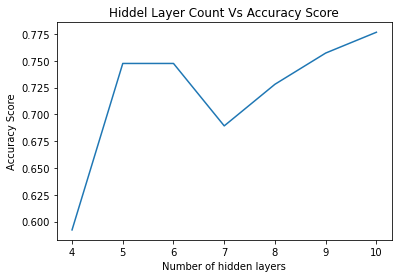

In [53]:
x = list(range(4, 11))
print(x)
print(accuracy_score_list)
plt.plot(x, accuracy_score_list)
plt.xlabel("Number of hidden layers") 
plt.ylabel("Accuracy Score") 
plt.title("Hiddel Layer Count Vs Accuracy Score") 
plt.show()

In [24]:
def model_base10_10():
    baseModel = Sequential()
    #Adding a layer with 10 nodes, 4 dimensional input with relu function.
    baseModel.add(Dense(10,input_dim=10,activation='relu'))
    baseModel.add(Dense(10,input_dim=10,activation='tanh'))
    #Adding a layer with 4 outputs and softmax function
    baseModel.add(Dense(4,activation='softmax'))
    #Compiling the model adam optimizer and sigmoid loss function
    baseModel.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    return baseModel

/var/folders/6q/1tr6dsz903s0r57yd4bx3jrm0000gn/T/ipykernel_3027/948296162.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier10_10 = KerasClassifier(build_fn=model_base10_10,epochs=300,batch_size=200,verbose=0)
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be rem

Baseline: 79.01% (5.62%)


/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


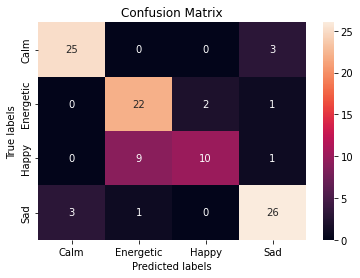

Accuracy for model:  0.8058252427184466


In [25]:
classifier10_10 = KerasClassifier(build_fn=model_base10_10,epochs=300,batch_size=200,verbose=0)
evaluate_model(classifier10_10, X, y_encoded)
classifier10_10 = predict(classifier10_10,X_train, y_train)
draw_confusion_matrix(y_test, classifier10_10)
accuracy = find_accuracy_score(y_test, classifier10_10)
print("Accuracy for model: " , accuracy)

In [57]:
from sklearn.metrics import classification_report
print(classification_report(y_test, classifier10_10))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        28
           1       0.69      0.88      0.77        25
           2       0.83      0.50      0.62        20
           3       0.84      0.87      0.85        30

    accuracy                           0.81       103
   macro avg       0.81      0.78      0.79       103
weighted avg       0.82      0.81      0.80       103



In [65]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(y_test)):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], classifier10_10[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [52]:
accuracy_score_list_epoch = []

/var/folders/6q/1tr6dsz903s0r57yd4bx3jrm0000gn/T/ipykernel_7149/3973509720.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier10_100 = KerasClassifier(build_fn=model_base10,epochs=100,batch_size=200,verbose=0)
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be remo

Baseline: 79.89% (5.36%)


/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


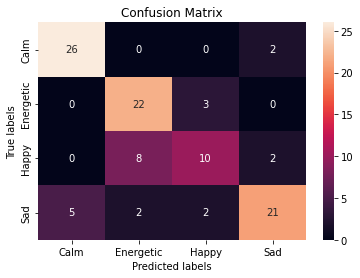

Accuracy for model with 10 hidden layers :  0.7669902912621359


In [35]:
classifier10_100 = KerasClassifier(build_fn=model_base10,epochs=100,batch_size=200,verbose=0)
evaluate_model(classifier10, X, y_encoded)
y_pred10 = predict(classifier10,X_train, y_train)
draw_confusion_matrix(y_test, y_pred10)
accuracy = find_accuracy_score(y_test, y_pred10)
print("Accuracy for model with 10 hidden layers : " , accuracy)
accuracy_score_list_epoch.append(accuracy)

/var/folders/6q/1tr6dsz903s0r57yd4bx3jrm0000gn/T/ipykernel_7149/2985743427.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier10_200 = KerasClassifier(build_fn=model_base10,epochs=200,batch_size=200,verbose=0)
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be remo

Baseline: 80.33% (2.87%)


/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


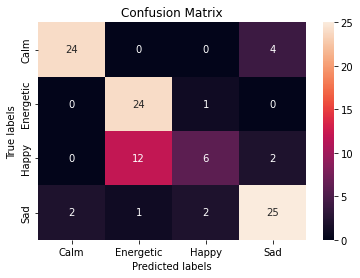

Accuracy for model with 10 hidden layers :  0.7669902912621359


In [36]:
classifier10_200 = KerasClassifier(build_fn=model_base10,epochs=200,batch_size=200,verbose=0)
evaluate_model(classifier10, X, y_encoded)
y_pred10 = predict(classifier10,X_train, y_train)
draw_confusion_matrix(y_test, y_pred10)
accuracy = find_accuracy_score(y_test, y_pred10)
print("Accuracy for model with 10 hidden layers : " , accuracy)
accuracy_score_list_epoch.append(accuracy)

/var/folders/6q/1tr6dsz903s0r57yd4bx3jrm0000gn/T/ipykernel_7149/3416855855.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier10_300 = KerasClassifier(build_fn=model_base10,epochs=300,batch_size=200,verbose=0)
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be remo

Baseline: 80.04% (5.07%)


/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


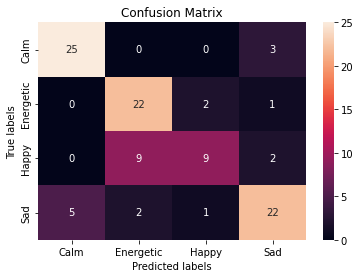

Accuracy for model with 10 hidden layers :  0.7572815533980582


In [37]:
classifier10_300 = KerasClassifier(build_fn=model_base10,epochs=300,batch_size=200,verbose=0)
evaluate_model(classifier10, X, y_encoded)
y_pred10 = predict(classifier10,X_train, y_train)
draw_confusion_matrix(y_test, y_pred10)
accuracy = find_accuracy_score(y_test, y_pred10)
print("Accuracy for model with 10 hidden layers : " , accuracy)
accuracy_score_list_epoch.append(accuracy)

/var/folders/6q/1tr6dsz903s0r57yd4bx3jrm0000gn/T/ipykernel_7149/2359665977.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier10_400 = KerasClassifier(build_fn=model_base10,epochs=400,batch_size=200,verbose=0)
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be remo

Baseline: 80.19% (5.28%)


/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


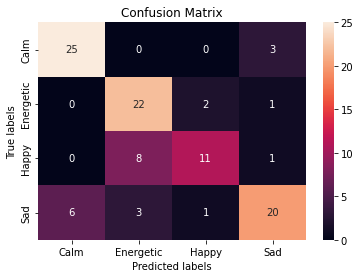

Accuracy for model with 10 hidden layers :  0.7572815533980582


In [38]:
classifier10_400 = KerasClassifier(build_fn=model_base10,epochs=400,batch_size=200,verbose=0)
evaluate_model(classifier10, X, y_encoded)
y_pred10 = predict(classifier10,X_train, y_train)
draw_confusion_matrix(y_test, y_pred10)
accuracy = find_accuracy_score(y_test, y_pred10)
print("Accuracy for model with 10 hidden layers : " , accuracy)
accuracy_score_list_epoch.append(accuracy)

/var/folders/6q/1tr6dsz903s0r57yd4bx3jrm0000gn/T/ipykernel_7149/1237848615.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier10_500 = KerasClassifier(build_fn=model_base10,epochs=500,batch_size=200,verbose=0)
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be remo

Baseline: 79.16% (5.49%)


/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


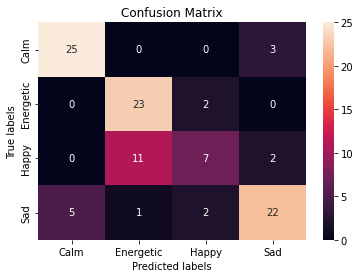

Accuracy for model with 10 hidden layers :  0.7475728155339806


In [39]:
classifier10_500 = KerasClassifier(build_fn=model_base10,epochs=500,batch_size=200,verbose=0)
evaluate_model(classifier10, X, y_encoded)
y_pred10 = predict(classifier10,X_train, y_train)
draw_confusion_matrix(y_test, y_pred10)
accuracy = find_accuracy_score(y_test, y_pred10)
print("Accuracy for model with 10 hidden layers : " , accuracy)
accuracy_score_list_epoch.append(accuracy)

/var/folders/6q/1tr6dsz903s0r57yd4bx3jrm0000gn/T/ipykernel_7149/1344346583.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier10_600 = KerasClassifier(build_fn=model_base10,epochs=600,batch_size=200,verbose=0)
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be remo

Baseline: 79.28% (5.43%)


/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


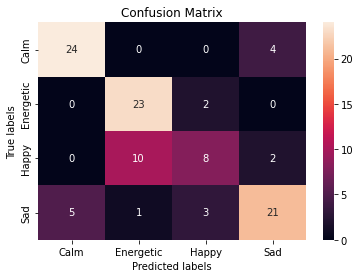

Accuracy for model with 10 hidden layers :  0.7378640776699029


In [40]:
classifier10_600 = KerasClassifier(build_fn=model_base10,epochs=600,batch_size=200,verbose=0)
evaluate_model(classifier10, X, y_encoded)
y_pred10 = predict(classifier10,X_train, y_train)
draw_confusion_matrix(y_test, y_pred10)
accuracy = find_accuracy_score(y_test, y_pred10)
print("Accuracy for model with 10 hidden layers : " , accuracy)
accuracy_score_list_epoch.append(accuracy)

/var/folders/6q/1tr6dsz903s0r57yd4bx3jrm0000gn/T/ipykernel_7149/22825039.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier10_700 = KerasClassifier(build_fn=model_base10,epochs=700,batch_size=200,verbose=0)
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be remove

Baseline: 78.73% (4.72%)


/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


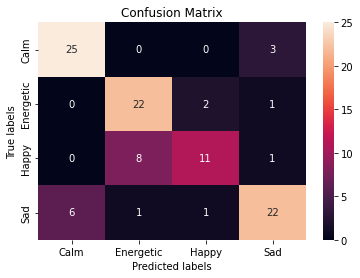

Accuracy for model with 10 hidden layers :  0.7766990291262136


In [41]:
classifier10_700 = KerasClassifier(build_fn=model_base10,epochs=700,batch_size=200,verbose=0)
evaluate_model(classifier10, X, y_encoded)
y_pred10 = predict(classifier10,X_train, y_train)
draw_confusion_matrix(y_test, y_pred10)
accuracy = find_accuracy_score(y_test, y_pred10)
print("Accuracy for model with 10 hidden layers : " , accuracy)
accuracy_score_list_epoch.append(accuracy)

/var/folders/6q/1tr6dsz903s0r57yd4bx3jrm0000gn/T/ipykernel_7149/1117833641.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier10_800 = KerasClassifier(build_fn=model_base10,epochs=800,batch_size=200,verbose=0)
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be remo

Baseline: 79.00% (7.15%)


/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


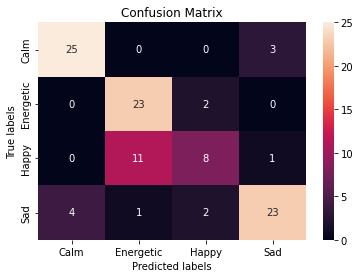

Accuracy for model with 10 hidden layers :  0.7669902912621359


In [42]:
classifier10_800 = KerasClassifier(build_fn=model_base10,epochs=800,batch_size=200,verbose=0)
evaluate_model(classifier10, X, y_encoded)
y_pred10 = predict(classifier10,X_train, y_train)
draw_confusion_matrix(y_test, y_pred10)
accuracy = find_accuracy_score(y_test, y_pred10)
print("Accuracy for model with 10 hidden layers : " , accuracy)
accuracy_score_list_epoch.append(accuracy)

/var/folders/6q/1tr6dsz903s0r57yd4bx3jrm0000gn/T/ipykernel_7149/1085026259.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier10_900 = KerasClassifier(build_fn=model_base10,epochs=900,batch_size=200,verbose=0)
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be remo

Baseline: 79.01% (4.24%)


/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


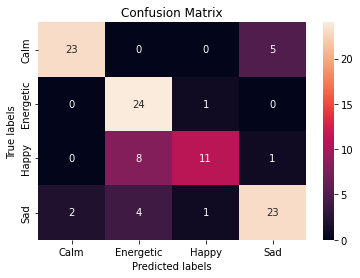

Accuracy for model with 10 hidden layers :  0.7864077669902912


In [43]:
classifier10_900 = KerasClassifier(build_fn=model_base10,epochs=900,batch_size=200,verbose=0)
evaluate_model(classifier10, X, y_encoded)
y_pred10 = predict(classifier10,X_train, y_train)
draw_confusion_matrix(y_test, y_pred10)
accuracy = find_accuracy_score(y_test, y_pred10)
print("Accuracy for model with 10 hidden layers : " , accuracy)
accuracy_score_list_epoch.append(accuracy)

/var/folders/6q/1tr6dsz903s0r57yd4bx3jrm0000gn/T/ipykernel_7149/3845818363.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  classifier10_1000 = KerasClassifier(build_fn=model_base10,epochs=1000,batch_size=200,verbose=0)
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be re

Baseline: 78.71% (5.33%)


/Users/sangeetha/venv-ml-pa1/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


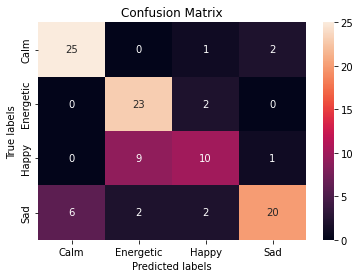

Accuracy for model with 10 hidden layers :  0.7572815533980582


In [44]:
classifier10_1000 = KerasClassifier(build_fn=model_base10,epochs=1000,batch_size=200,verbose=0)
evaluate_model(classifier10, X, y_encoded)
y_pred10 = predict(classifier10,X_train, y_train)
draw_confusion_matrix(y_test, y_pred10)
accuracy = find_accuracy_score(y_test, y_pred10)
print("Accuracy for model with 10 hidden layers : " , accuracy)
accuracy_score_list_epoch.append(accuracy)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
[0.6990291262135923, 0.7766990291262136, 0.7475728155339806, 0.7378640776699029, 0.7281553398058253, 0.7475728155339806, 0.7766990291262136]


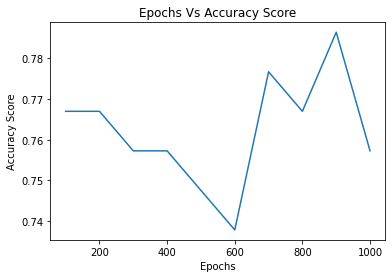

In [46]:
x = list(range(100, 1100, 100))
print(x)
print(accuracy_score_list)
plt.plot(x, accuracy_score_list_epoch)
plt.xlabel("Epochs") 
plt.ylabel("Accuracy Score") 
plt.title("Epochs Vs Accuracy Score")
plt.show()